# Convolutional Neuronal Network with MNIST Digits database

In this project, we will use CNN to clasify digits from MNIST database.

## Preparation

Import the necessary libraries to use.

In [77]:
# Pytorch

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

In [78]:
# Graphing

import matplotlib.pylab as plt
import numpy as np

Let's define the function for plotting.

In [79]:
def plot_channels(W):
    n_out = W.shape[0]
    n_in = W.shape[1]
    w_min = W.min().item()
    w_max = W.max().item()

    fig, axes = plt.subplots(n_out, n_in)
    fig.subplots_adjust(hspace=0.1)
    out_index = 0
    in_index = 0

    # plot outputs as rows, inputs as columns

    for ax in axes.flat:
        if in_index > n_in - 1:
            out_index = out_index+1
            in_index = 0

        ax.imshow(W[out_index, in_index, :, :],
                  vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        in_index = in_index+1

    plt.show()

The plot_parameters function is use to plot out the kernel parameters of each channel with multiple outputs.

In [80]:
def plot_parameters(W, number_rows=1, name="", i=0):
    W = W.data[:, i, :, :]
    n_filters = W.shape[0]
    w_min = W.min().item()
    w_max = W.max().item()

    fig, axes = plt.subplots(number_rows, n_filters // number_rows)
    fig.subplots_adjust(hspace=0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            ax.set_xlabel("Kernel:{0}".format(i + 1))

            ax.imshow(W[i, :], vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])

    plt.suptitle(name, fontsize=10)
    plt.show()

Define the plot_activation function to plot out the activations of the Convolutional layers.

In [81]:
def plot_activations(A, number_rows=1, name="", i=0):
    A = A[0, :, :, :].detach().numpy()
    n_activations = A.shape[0]
    A_min = A.min().item()
    A_max = A.max().item()

    fig, axes = plt.subplots(number_rows, n_activations // number_rows)
    fig.subplots_adjust(hspace=0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_activations:
            ax.set_xlabel("activation:{0}".format(i + 1))

            ax.imshow(A[i, :], vmin=A_min, vmax=A_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])

    plt.show()

And, the function show_data to plot out data samples as images.

In [82]:
def show_data(data_sample):
    image = data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE)
    label = data_sample[1]
    
    plt.imshow(image, cmap='gray')
    plt.title('Label: ' + str(label))
    
    # Agregar los valores de intensidad limitados a 1 decimal en cada píxel
    for i in range(IMAGE_SIZE):
        for j in range(IMAGE_SIZE):
            intensity = round(image[i, j], 1)
            plt.text(j, i, str(intensity), color='black', fontsize=8, ha='center', va='center')

## Get Data

Transformers to resize the image and convert it to a tensor.

In [83]:
IMAGE_SIZE = 16

TR_Resize = transforms.Resize((IMAGE_SIZE, IMAGE_SIZE))
TR_toTensor = transforms.ToTensor()

composed = transforms.Compose([TR_Resize, TR_toTensor])

Load the training and validation dataset.

In [84]:
train_data = dsets.MNIST(root='./data', train=True, transform=composed, download=True)
val_data = dsets.MNIST(root='./data', train=False, transform=composed, download=True)

Each element in the rectangular tensor corresponds to a number intensity:

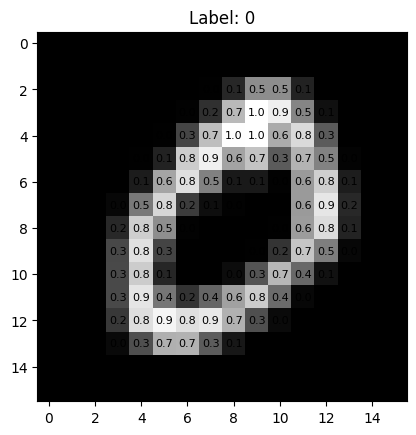

In [85]:
show_data(train_data[1])

## CONVOLUTIONAL NEURONAL NETWORK CLASS

Build a CNN class with two convolutional layers and one fully connected layer. The parameters in the constructor are the number of output channels for the first and second layers.

In [86]:
class CNN(nn.Module):

    # Constructor
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(
            in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(
            in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, 10)

    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
    
    # Outputs in each steps
    def activations(self, x):
        z1 = self.cnn1(x)
        a1 = torch.relu(z1)
        out = self.maxpool1(a1)
        
        z2 = self.cnn2(out)
        a2 = torch.relu(z2)
        out1 = self.maxpool2(a2)
        out = out.view(out.size(0),-1)
        return z1, a1, z2, a2, out1,out

## Define the CNN classifier, Criterion function, Optimizer

There are 16 outputs channels in the first layer and 32 output channels en the second layer.

In [87]:
model = CNN(out_1=16, out_2=32)

Plot the model parameters for the kernel before training the kernels. The kernels are initialized randomly.

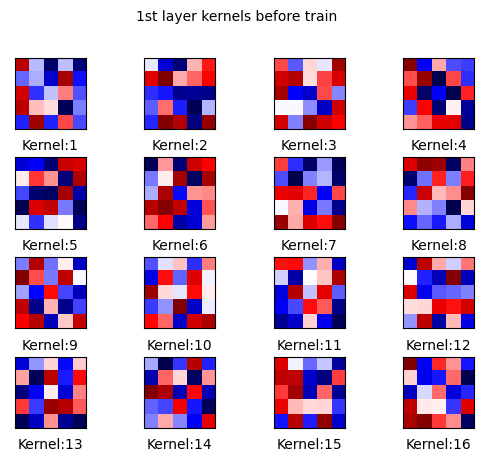

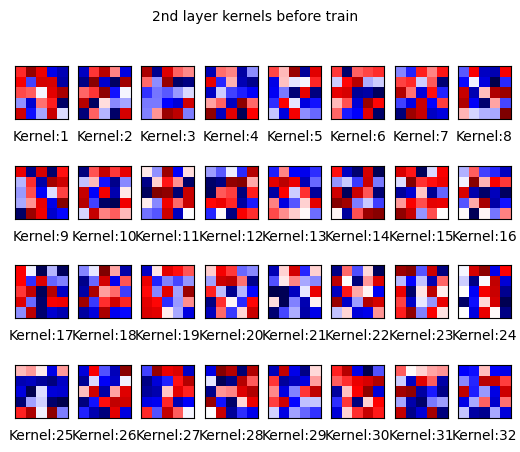

In [88]:
plot_parameters(model.state_dict()[
                'cnn1.weight'], number_rows=4, name='1st layer kernels before train')
plot_parameters(model.state_dict()[
                'cnn2.weight'], number_rows=4, name='2nd layer kernels before train')

## Train the model

Define the loss function, the optimizer and the dataset loader.

In [89]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=100)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=5000)

Train the model and determine validation accuracy technically test accuracy.

In [90]:
n_epochs = 3
cost_list = []
accuracy_list = []
N_test = len(val_data)
COST = 0


def train_model(n_epochs):
    for epoch in range(n_epochs):
        COST = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            COST += loss.data

        cost_list.append(COST)
        correct = 0

        # Prediction on the validation data
        for x_test, y_test in val_loader:
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        
        accuracy = correct / N_test
        accuracy_list.append(accuracy)

train_model(n_epochs)